In [1]:
import pymssql
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import sqlalchemy
from sqlalchemy  import create_engine
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from collections import Counter

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  """Entry point for launching an IPython kernel.


In [2]:
############################### Database Connections ######################################
# AWS
server = 'pfidb.ci3ir6nuotoi.sa-east-1.rds.amazonaws.com'
user = 'admin'
password = 'AramLucas2020.'
db = 'pfidb'

# Local DB PC
# server = 'DESKTOP-3OHRULK'
# user = 'sa'
# password = 'welcome1'
# db = 'pfidb'

# Connection to DB
conn = pymssql.connect(server,user,password,db)

#Connection using sqlAlchemy
conn_for_insert = fr'mssql+pymssql://'+user+':'+password+'@'+server+'/'+db
engine = create_engine(conn_for_insert)

In [3]:
#Query that retrives the usage of the stations
# query = open("master_query_v3.sql","r")
# df_stations_usage = pd.read_sql_query(query.read(),conn)

stations_query = """SELECT * FROM [estaciones-de-bicicletas-publicas]"""
# stations_query = """SELECT * FROM [estaciones-bicicletas-publicas-2019]"""
df_stations = pd.read_sql(stations_query,conn)


In [4]:
coords = df_stations.as_matrix(columns=['lat', 'long'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


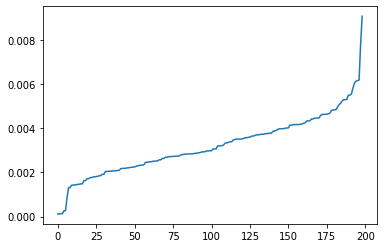

In [5]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(coords)
distances, indices = nbrs.kneighbors(coords)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [41]:
# DBSCAN using ball_tree algorithm and haversine metric

kms_per_radian = 6371.0088
epsilon = 0.005 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))
# np.array(np.unique(cluster_labels, return_counts=True)).T

Number of clusters: 199


In [43]:
# Showing silhouette score can't be generated using ball_tree and haversine because there as are many clusters as stations
labels = db.labels_
print(silhouette_score(coords, labels))

ValueError: Number of labels is 199. Valid values are 2 to n_samples - 1 (inclusive)

In [55]:
# DBSCAN using auto algorithm and euclidean metric

epsilon = 0.005
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='auto'
            , metric='euclidean').fit(coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 35


In [52]:
# Showing silhouette score for DBSCAN with Euclidean distance
labels = db.labels_
print(silhouette_score(coords, labels))

-0.21062368179332802


In [50]:
# DBSCAN using automatic algorithm and manhattan metric

epsilon = 0.005
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='auto'
            , metric='manhattan').fit(coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 77


In [46]:
# Showing silhouette score with Manhattan distance
labels = db.labels_
print(silhouette_score(coords, labels))

0.059652226630949184


In [11]:
# cluster_labels
np.array(np.unique(cluster_labels, return_counts=True)).T

array([[  0,   1],
       [  1, 124],
       [  2,   1],
       [  3,   6],
       [  4,   1],
       [  5,   1],
       [  6,   5],
       [  7,   5],
       [  8,   3],
       [  9,   6],
       [ 10,   2],
       [ 11,   4],
       [ 12,   1],
       [ 13,   2],
       [ 14,   2],
       [ 15,   4],
       [ 16,   1],
       [ 17,   5],
       [ 18,   2],
       [ 19,   1],
       [ 20,   2],
       [ 21,   1],
       [ 22,   2],
       [ 23,   1],
       [ 24,   1],
       [ 25,   1],
       [ 26,   2],
       [ 27,   2],
       [ 28,   1],
       [ 29,   1],
       [ 30,   1],
       [ 31,   1],
       [ 32,   1],
       [ 33,   1],
       [ 34,   1],
       [ 35,   1],
       [ 36,   1],
       [ 37,   1]], dtype=int64)

In [12]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [24]:
lats, longs = zip(*centermost_points)
rep_points = pd.DataFrame({'long':longs, 'lat':lats})

In [20]:
rs = rep_points.apply(lambda row: df_stations[(df_stations['lat']==row['lat']) & (df_stations['long']==row['long'])].iloc[0], axis=1)

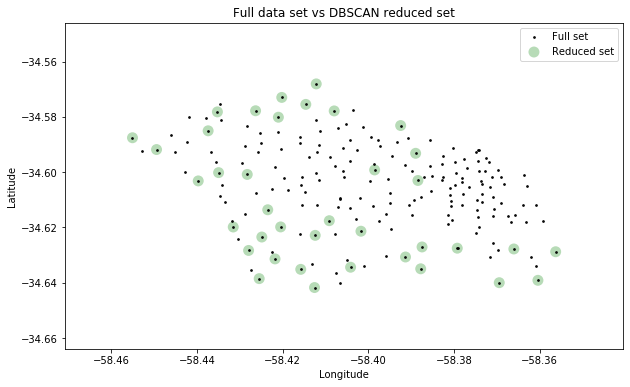

In [26]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['long'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df_stations['long'], df_stations['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()